In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
import saopaulo.cycling_potential as cp
from bikescience.slope import plot_slope, plot_slopes, split_route
from shapely.geometry import LineString
import ast

from math import floor

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time
import scipy.stats as st

# read routes files and join with general trips file
od_trips = pd.read_csv('../data/sao-paulo/od/OD_2017.csv')
od_trips.columns = [c[: c.index(',')] for c in od_trips.columns]
od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_all.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}
od_routes_sp['length'] = od_routes_sp['geometry'].length * 100000

routes_pedestrian = pd.read_csv('../data/sao-paulo/rotas-migracao/routes_pedestrians_to_bike.csv')
routes_pedestrian.set_index('trip_id', inplace=True, drop=False)
routes_pedestrian = routes_pedestrian.join(other = od_trips, how = 'left')
routes_pedestrian = gpd.GeoDataFrame(routes_pedestrian, crs={'init': 'epsg:4326'}, 
                                     geometry=[LineString(ast.literal_eval(r)) for r in routes_pedestrian.route])
routes_pedestrian['length'] = routes_pedestrian['geometry'].length * 100000

routes_car = pd.read_csv('../data/sao-paulo/rotas-migracao/new_routes_cars_to_bike.csv')
routes_car.set_index('trip_id', inplace=True, drop=False)
routes_car = routes_car.join(other = od_trips, how = 'left')
routes_car = gpd.GeoDataFrame(routes_car, crs={'init': 'epsg:4326'}, 
                              geometry=[LineString(ast.literal_eval(r)) for r in routes_car.route])
routes_car['length'] = routes_car['geometry'].length * 100000

the_grid = gr.create(n=10, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '../data/sao-paulo/rotas-migracao/routes_pedestrians_to_bike.csv'

In [ ]:
df = routes_pedestrian
def stats (data, value, weights = 'FE_VIA'):
    level = sum(data[weights])/10
    stats = []
    data = data.sort_values(value)
    total = 0
    for _, i in data.iterrows():
        total += i[weights]
        if total >= (len(stats) + 1) * level - 1e-5:
            stats.append(i[value])
    return stats

s = stats(df, 'length')
    
plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=df['length'], 
         weights = df['FE_VIA'],range=(0, 25000))
plt.title('São Paulo pedestrian trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()    

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0, 25000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show() 

df = routes_car
s = stats(df, 'length')
        
plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=df['length'], 
         weights = df['FE_VIA'],range=(0, 25000))
plt.title('São Paulo car trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()    

In [4]:
cp_list = []
for i, r in od_routes_sp.iterrows():
    pot_d, pot_a, pot_i = cp.cycling_potential_variables(r)
    cp_list.append(['bike', r['ID_ORDEM'], pot_d, pot_a, pot_i, 1, r['FE_VIA']])
    
for i, r in routes_pedestrian.iterrows():
    try:
        pot_d, pot_a, pot_i = cp.cycling_potential_variables(r)
        cp_list.append(['pedestrian', i, pot_d, pot_a, pot_i, 0])
    except:
        print(i, '- broken case')
    
for i, r in routes_car.iterrows():
    try:
        pot_d, pot_a, pot_i = cp.cycling_potential_variables(r)
        cp_list.append(['car', i, pot_d, pot_a, pot_i, 0])
    except:
        print(i, '- broken case')

3604.0 - broken case
3605.0 - broken case
4798.0 - broken case
4799.0 - broken case
4802.0 - broken case
4803.0 - broken case
6716.0 - broken case
6717.0 - broken case
58435.0 - broken case
58436.0 - broken case
58437.0 - broken case
58438.0 - broken case
61341.0 - broken case
61342.0 - broken case
76031.0 - broken case
76032.0 - broken case
85194.0 - broken case
85195.0 - broken case
85196.0 - broken case
85197.0 - broken case
86627.0 - broken case
86628.0 - broken case
98668.0 - broken case
98669.0 - broken case
108235.0 - broken case
108236.0 - broken case
108237.0 - broken case
108238.0 - broken case
108247.0 - broken case
108248.0 - broken case
108249.0 - broken case
110315.0 - broken case
110316.0 - broken case
111532.0 - broken case
111533.0 - broken case
122637.0 - broken case
122638.0 - broken case
166223.0 - broken case
166224.0 - broken case
166225.0 - broken case
166226.0 - broken case
166227.0 - broken case
166228.0 - broken case
166229.0 - broken case
166230.0 - broken ca

In [5]:
columns = ['modal', 'trip_id', 'distance_potential', 'age_potential', 'inclination_potential', 'is_bike']
df_cycling_potential = pd.DataFrame(data = cp_list, columns = columns)

display (df_cycling_potential)

,modal,trip_id,distance_potential,age_potential,inclination_potential,is_bike
0,bike,450.0,0.907533,0.045080,0.303321,1
1,bike,451.0,0.826459,0.045080,0.653719,1
2,bike,452.0,0.907533,0.045080,0.303321,1
3,bike,453.0,0.826459,0.045080,0.653719,1
4,bike,454.0,0.823677,0.045080,0.577235,1
...,...,...,...,...,...,...
100426,car,182862.0,0.319052,0.323018,0.149319,0
100427,car,183002.0,0.000962,0.848482,0.001314,0
100428,car,183003.0,0.001228,0.848482,0.001610,0
100429,car,183076.0,0.006880,0.075749,0.018508,0


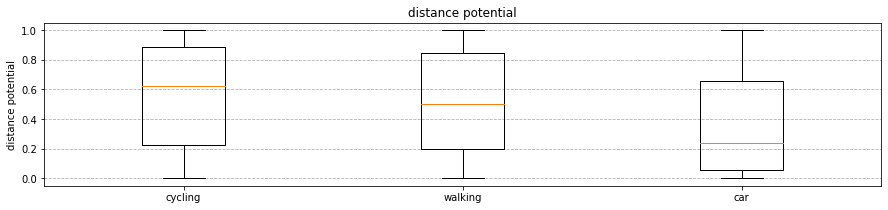

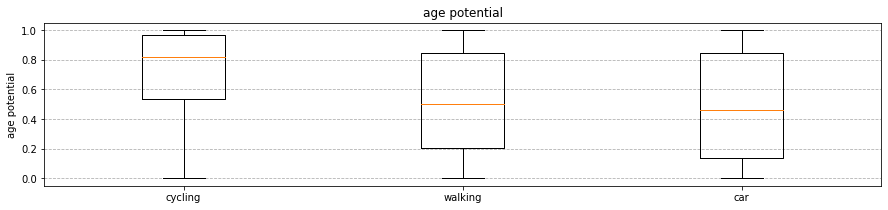

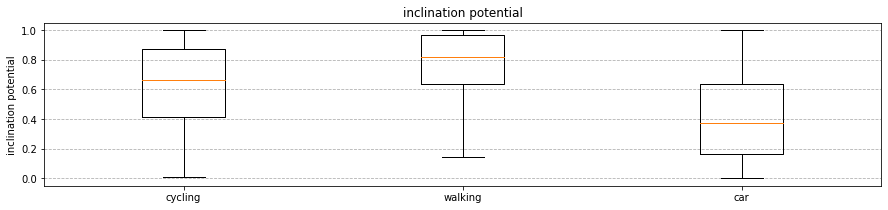

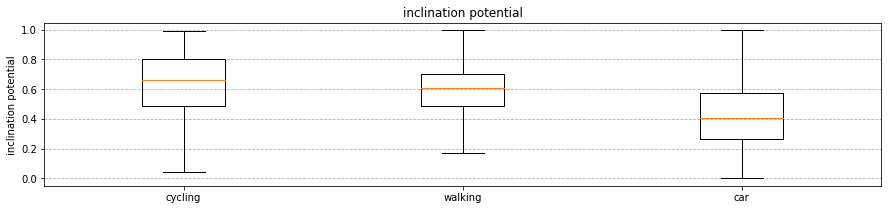

In [15]:
plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot([df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']['distance_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'pedestrian']['distance_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'car']['distance_potential']],
           showfliers=False)
plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('distance potential')
plt.ylabel('distance potential')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot([df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']['age_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'pedestrian']['age_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'car']['age_potential']],
           showfliers=False)
plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('age potential')
plt.ylabel('age potential')
plt.show()

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot([df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']['inclination_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'pedestrian']['inclination_potential'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'car']['inclination_potential']],
           showfliers=False)
plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('slope potential')
plt.ylabel('slope potential')
plt.show()

df_cycling_potential['total'] = (df_cycling_potential['inclination_potential'] + 
                                 df_cycling_potential['age_potential'] + 
                                 df_cycling_potential['distance_potential'])/3

plt.figure(figsize=(15,3))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot([df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']['total'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'pedestrian']['total'],
             df_cycling_potential.loc[df_cycling_potential['modal'] == 'car']['total']],
           showfliers=False)
plt.xticks([1, 2, 3], ['cycling', 'walking', 'car'])
plt.title('final potential')
plt.ylabel('final potential')
plt.show()

In [7]:
#fmap = gr.map_around_sp(the_grid=None,zoom=11,plot_grid=False)

#for _, r in od_routes_sp.iterrows():
#    p = cp.partial_cycling_potential ('distance', r['SEXO'], r['length'])
#    if p > .8:
#        color='#2acf06'
#    elif p > .6:
#        color='#8ae736'
#    elif p > .4:
#        color='ecff1e'
#    elif p > .2:
#        color='#f7d202'
#    else:
#        color='#ff1e1e'
#    folium.GeoJson(r['geometry'], 
#                   control=False, 
#                   style_function=lambda style, color_p=color :{'color': color_p, 'weight': 1}).add_to(fmap)
    
#display(fmap)

### Linear regression to estimate values

In [16]:
import statsmodels.api as sm

df_cycling_potential['slope_potential'] = df_cycling_potential['inclination_potential']
X = df_cycling_potential[['distance_potential', 'age_potential', 'slope_potential']]
y = df_cycling_potential['is_bike']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                is_bike   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.015
Method:                 Least Squares   F-statistic:                              512.1
Date:                Wed, 15 Dec 2021   Prob (F-statistic):                        0.00
Time:                        22:00:00   Log-Likelihood:                          90636.
No. Observations:              100431   AIC:                                 -1.813e+05
Df Residuals:                  100428   BIC:                                 -1.812e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
distance_potential     0.0094      0.001     10.484      0.000       0.008       0.011
age_potential          0.0162      0.001     21.753      0.000       0.015       0.018
slope_potential       -0.0033      0.001     -3.911      0.000      -0.005      -0.002
==============================================================================
Omnibus:                   152426.790   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         40585838.393
Skew:                           9.902   Prob(JB):                         0.00
Kurtosis:                      99.471   Cond. No.                         3.45
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
display(model.pvalues)

distance_potential     1.050501e-25
age_potential         1.128918e-104
slope_potential        9.190740e-05
dtype: float64

In [9]:
def plot_route_potential (id_route):
    r = od_routes_sp.loc[od_routes_sp['ID_ORDEM'] == id_route].iloc[0]
    r_split = split_route(r['geometry'], 10)
    
    fmap = gr.map_around_sp(the_grid=None,zoom=15,plot_grid=False)
    plot_slope(fmap, r['geometry'], 'line')
    display(fmap)
    

    heights = [line[0].coords[0][2] for line in r_split]
    slopes = [line[1] for line in r_split]
    lengths = [i * 10 for i in range(len(heights))]

    plt.figure(figsize=(15,5))
    plt.plot(lengths, heights, label='altitude')
    plt.ylabel('altitude (metros)')
    plt.xlabel('metros')
    plt.show()

    plt.figure(figsize=(15,5))
    plt.hist(bins=50,x=[round(s) for s in slopes], weights = [10]*len(slopes))
    plt.title('Metros percorridos em cada inclinação)')
    plt.xlabel('declividade')
    plt.ylabel('metros percorridos')
    plt.show()

    pot = cp.cycling_potential_variables(r)
    print('Distance potential:    ', pot[0], '\tDistance: ', r['length'])
    print('Age potential:         ', pot[1], '\tAge:      ', r['IDADE'])
    print('Inclination potential: ', pot[2])
    print('\nGender:')
    print('1 = M, 2 = F           ', r['SEXO'])

In [10]:
def filter(age_min = None, age_max = None,
           distance_min = None, distance_max = None, 
           inclination_min = None, inclination_max = None,
           total_min = None, total_max = None):
    
    aux = df_cycling_potential.loc[df_cycling_potential['modal'] == 'bike']
    aux['total'] = (aux['age_potential'] + aux['distance_potential'] + aux['inclination_potential']) / 3
    if age_min is not None:
        aux = aux.loc[aux['age_potential'] >= age_min]
    if age_max is not None:
        aux = aux.loc[aux['age_potential'] <= age_max]
    if distance_min is not None:
        aux = aux.loc[aux['distance_potential'] >= distance_min]
    if distance_max is not None:
        aux = aux.loc[aux['distance_potential'] <= distance_max]
    if inclination_min is not None:
        aux = aux.loc[aux['inclination_potential'] >= inclination_min]
    if inclination_max is not None:
        aux = aux.loc[aux['inclination_potential'] <= inclination_max]
    if total_min is not None:
        aux = aux.loc[aux['total'] >= total_min]
    if total_max is not None:
        aux = aux.loc[aux['total'] <= total_max]
    return aux

In [11]:
#aux = filter(age_min=0.9, age_max=1)
#aux = filter(inclination_min=0.5, inclination_max=1, distance_max=0.5)
#aux = filter(total_min=0.5, inclination_max=0.3)
#display(aux)


aux = filter(total_min=0.57, total_max=0.58)
display(aux)

,modal,trip_id,distance_potential,age_potential,inclination_potential,is_bike,total
10,bike,460.0,0.977519,0.243473,0.516038,1,0.579010
50,bike,2730.0,0.729327,0.242799,0.748239,1,0.573455
65,bike,2827.0,0.697207,0.153918,0.882707,1,0.577944
89,bike,3533.0,0.380590,0.331021,1.000000,1,0.570537
122,bike,7585.0,0.817208,0.429568,0.477632,1,0.574803
140,bike,9610.0,0.829957,0.395515,0.486714,1,0.570729
246,bike,23880.0,0.976567,0.052490,0.681097,1,0.570051
295,bike,26740.0,0.310040,0.998432,0.424712,1,0.577728
326,bike,28155.0,0.269104,0.728141,0.732302,1,0.576516
352,bike,29508.0,0.876471,0.173652,0.676480,1,0.575534


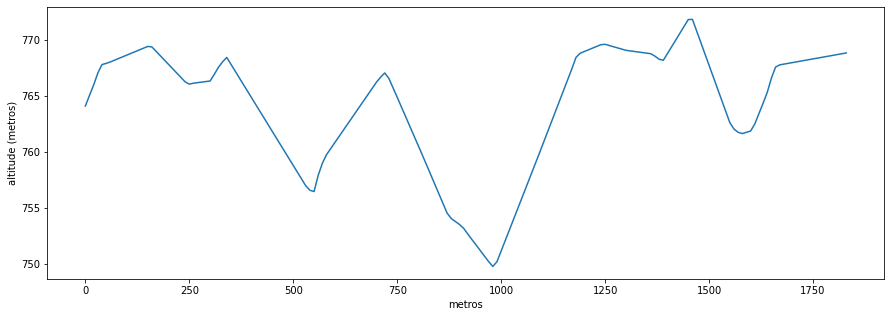

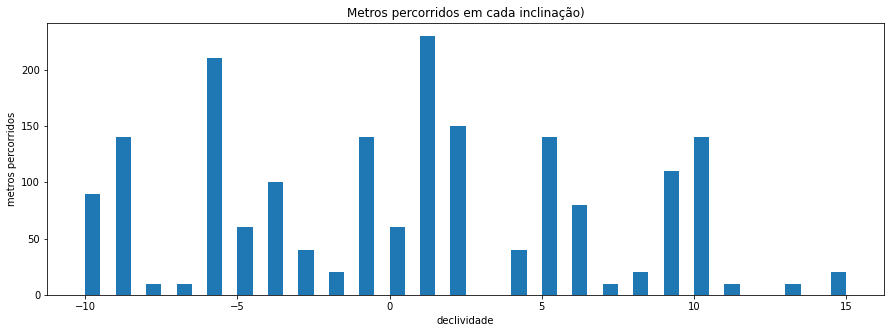

Distance potential:     0.9718911347425093 	Distance:  1837.5642051510144
Age potential:          0.9514554737401426 	Age:       27
Inclination potential:  0.24667487947486744

Gender:
1 = M, 2 = F            1


In [12]:
plot_route_potential(902)